# 멀티에이전트 슈퍼바이저 패턴

멀티 에이전트를 효율적으로 구성하기 위해서 몇가지 패턴이 존재합니다.

![multi_agent_architectures](statics/03_multi_agent_architectures.png)

이번 튜토리얼에서는 슈퍼바이저(Supervisor) 패턴을 구현하겠습니다. 슈퍼바이저 여러 전문 에이전트들을 중앙의 감독자(supervisor) 에이전트가 조율하는 **멀티 에이전트 아키텍처**입니다. 슈퍼바이저는 모든 커뮤니케이션 흐름과 작업 분배를 제어하며, 현재 상황(context)과 작업 요구사항에 따라 어떤 에이전트를 호출할지 결정합니다.

이 튜토리얼에서는 **리서치 전문가 에이전트** 와 **계산 전문가 에이전트**, 총 두 개의 전문 에이전트를 갖춘 supervisor 시스템을 구축하게 됩니다.  

<img src="https://langchain-ai.github.io/langgraphjs/tutorials/multi_agent/img/supervisor-diagram.png" />

## 1. 환경설정

### `.env` 설정

### 패키지 설정

In [1]:
%pip install -qU python-dotenv langgraph langsmith langchain-openai langchain-tavily

Note: you may need to restart the kernel to use updated packages.


In [31]:
# 환경 변수 확인
from dotenv import load_dotenv
import os
load_dotenv(override=True)

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

print(os.environ.get("OPENAI_API_KEY")[:10])
print(os.environ.get("TAVILY_API_KEY")[:10])

sk-proj-8xZc3Ppf7BtK
tvly-dev-GUT1o6jP4Og


### 메세지 프린트 함수
그래프의 실행 결과인 메세지를 확인하기 편리하도록 함수를 준비합니다.

In [32]:
# hide-cell
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

## 2. 에이전트 생성

먼저, 두 개의 전문 워커 에이전트인 리서치 에이전트와 수학 에이전트를 만들어보겠습니다:

- 리서치 에이전트는 Tavily API를 사용한 웹 검색 도구에 접근할 수 있습니다.
- 수학 에이전트는 더하기, 곱하기, 나누기와 같은 간단한 수학 도구에 접근할 수 있습니다.

### 리서치 에이전트 (노드)

In [33]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)

In [34]:
# 도구 테스트 
web_search_results = web_search.invoke("2025년 미국의 대통령은 누구인가?")
web_search_results["results"][0]["content"]

'도널드 존 트럼프(영어: Donald John Trump, 1946년 6월 14일~)는 미국의 기업인, 부동산 재벌 출신 정치인이다. 미국의 제45, 47대 대통령이다.'

`create_react_agent`함수로 만들어진 에이전트를 호출하고, 그 결과에 따라서 상태(State)를 업데이트하고, 다음 실행될 노드(Node)를 결정하는 `search_node`를 구현한다.

In [35]:
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage

def search_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    research_agent = create_react_agent(
        model="openai:gpt-4o-mini",
        tools=[web_search],
        prompt=(
            "당신은 리서치 에이전트입니다.\n\n"
            "지침:\n"
            "- 오직 리서치(조사) 관련 작업만 도와야 하며, 수학 계산은 절대 하지 마세요\n"
            "- 작업이 완료되면 결과를 감독자(supervisor)에게 바로 전달하세요\n"
            "- 작업 결과만 응답하세요. 그 외의 텍스트는 절대 포함하지 마세요."
    
        ),
        name="research_agent",
    )

    print("===== SEARCH AGENT =====")
    
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )

구현된 노드를 테스트합니다.

In [36]:
## 테스트 

# 테스트용 입력 생성
initial_state = MessagesState(messages=[
    HumanMessage(content="2025년 현재 미국의 대통령은 누구인가?", name="user")
])

# 함수 호출 및 결과 확인
result = search_node(initial_state)

# 6. 출력 보기
print("🔍 DB 쿼리 결과:")
for msg in result.update["messages"]:
    print(f"[{msg.name}] {msg.content}")
print(f"다음 이동: {result.goto}")

===== SEARCH AGENT =====
🔍 DB 쿼리 결과:
[rag] 2025년 현재 미국의 대통령은 조 바이든입니다.
다음 이동: supervisor


### 수학 에이전트 (노드)

수학적인 계산을 담당하는 커스텀 도구를 생성합니다.

In [37]:
from langchain_core.tools import tool

@tool
def add(a: float, b: float):
    """Add two numbers."""
    return a + b

@tool
def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b

@tool
def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b

`create_react_agent`함수로 만들어진 에이전트를 호출하고, 그 결과에 따라서 상태(State)를 업데이트하고, 다음 실행될 노드(Node)를 결정하는 `math_node`를 구현한다.

In [38]:
# from langchain.agents import create_react_agent
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

def math_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    math_agent = create_react_agent(
        model=model,
        tools=[add, multiply, divide],
        prompt=(
            "당신은 수학 에이전트입니다.\n\n"
            "지침:\n"
            "- 오직 수학 관련 작업만 도와야 합니다\n"
            "- 작업이 완료되면 결과를 감독자(supervisor)에게 바로 전달하세요\n"
            "- 작업 결과만 응답하세요. 그 외의 텍스트는 절대 포함하지 마세요."
        ),
        name="math_agent",
    )

    print("===== MATH AGENT =====")

    result = math_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )

math_node를 테스트 합니다.

In [39]:
## 테스트 

# 테스트용 입력 생성
initial_state = MessagesState(messages=[
    HumanMessage(content="(2 + 4) **3 의 계산 결과는?", name="user")
])

# 함수 호출 및 결과 확인
result = math_node(initial_state)

# 6. 출력 보기
print("🔍 DB 쿼리 결과:")
for msg in result.update["messages"]:
    print(f"[{msg.name}] {msg.content}")
print(f"다음 이동: {result.goto}")

===== MATH AGENT =====
🔍 DB 쿼리 결과:
[rag] 216.0
다음 이동: supervisor


### 👷 슈퍼바이저 에이전트 
`langgraph-supervisor`라이브러리를 사용하여 에이전트 생성하기

In [40]:
from pydantic import BaseModel, Field

# LLM출력을 구조화하기위한 클래스 
class Router(BaseModel):
    next: Literal["search_agent", "math_agent", "__end__"] = Field(
        description="워크플로우 순서에서 다음으로 실행할 전문가를 결정합니다: "
                    "'research_agent'는 사용자 입력에 웹 검색이 필요한 경우 사용됩니다. "
                    "'math_agent'는 수학적 계산을 실행하는 경우 사용됩니다. "
    )
    reason: str = Field(
        description="특정 전문가를 선택한 이유와 이 선택이 과업을 완수하는 데 어떻게 기여하는지를 설명합니다."
    )

In [41]:
def supervisor_node(state: MessagesState) -> Command[Literal["search_agent", "math_agent", "__end__"]]:

    system_prompt = ('''

        "당신은 두 개의 전문가 에이전트를 관리하는 감독자입니다:\n"
        "- 'research_agent': 사용자 입력에 웹 검색이 필요한 경우 이 에이전트에게 할당하세요\n"
        "- 'math_agent': 수학적 계산을 실행하는 경우 이 에이전트에게 할당하세요\n"
        "한 번에 하나의 에이전트에게만 작업을 할당하고, 에이전트를 병렬로 호출하지 마세요.\n"
        "당신 스스로는 어떤 작업도 수행하지 마세요."
        
        **당신의 책임**:
        1. 각 결정 시점에서 작업을 가장 적절한 에이전트에게 라우팅합니다.
        2. 중복되는 에이전트 할당을 피하여 워크플로우의 효율성을 유지합니다.
        3. 사용자의 질문에 대한 충분한 응답이 생성되었고, 더 이상 추가적인 작업이 필요하지 않다면 'FINISH' 또는 '__end__'를 리턴하십시오.
    ''')

       
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    supervisor = create_react_agent(
        model=model,
        tools=[],
        prompt=system_prompt,
        response_format=Router,
        name="supervisor",
    )

    response = supervisor.invoke(state)
    # print("📌 RESPONSE", response)
    
    goto = response["structured_response"].next
    reason = response["structured_response"].reason
    
    if goto == "FINISH" or goto == "__end__":
        goto = END
    
    print(f"📌--- Workflow Transition: Supervisor → {goto.upper()} ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto,
    )

## 3. 그래프 생성

In [42]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(MessagesState)
builder.add_node("supervisor", supervisor_node)
builder.add_node("search_agent", search_node)
builder.add_node("math_agent", math_node)
builder.add_edge(START, "supervisor")
graph = builder.compile()

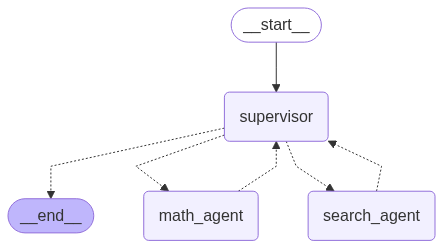

In [43]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 4. 실행

In [51]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "2024년 미국 전체 GDP와 뉴욕주의 GDP를 찾아줘.그리고 뉴욕주의 GDP가 미국 GDP의 몇 퍼센트인지 `math_agent`로 계산해줘.",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

📌--- Workflow Transition: Supervisor → SEARCH_AGENT ---
Update from node supervisor:


================================ Human Message =================================
Name: supervisor

2024년 미국 전체 GDP와 뉴욕주의 GDP를 찾아야 하기 때문에 'search_agent'를 사용합니다.


===== SEARCH AGENT =====
Update from node search_agent:


================================ Human Message =================================
Name: rag

2024년 미국의 GDP는 약 26.5조 달러이며, 뉴욕주의 GDP는 약 2.297조 달러입니다.


📌--- Workflow Transition: Supervisor → MATH_AGENT ---
Update from node supervisor:


================================ Human Message =================================
Name: supervisor

뉴욕주의 GDP가 미국 GDP의 몇 퍼센트인지 계산하기 위해 수학적 계산이 필요합니다.


===== MATH AGENT =====
Update from node math_agent:


================================ Human Message =================================
Name: rag

뉴욕주의 GDP는 미국 GDP의 약 8.67%입니다.




Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


📌--- Workflow Transition: Supervisor → __END__ ---
Update from node supervisor:


================================ Human Message =================================
Name: supervisor

2024년 미국 전체 GDP와 뉴욕주의 GDP를 찾아서 뉴욕주의 GDP가 미국 GDP의 약 8.67%임을 계산했습니다.




## END